In [46]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import os.path as osp
import seaborn as sns
from typing import List
import matplotlib.pyplot as plt

import torch
from torch.nn.functional import one_hot 
from datetime import datetime

import tensorflow as tf
from tensorflow.keras import losses
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import load_model


from src.models.classifiers import CNNtf
import src.cf_methods.countergan.utils  as cutils

tf.experimental.numpy.experimental_enable_numpy_behavior()

plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
from src.utils import seed_tf

seed_tf()

Loading MNIST data

In [78]:
DESIRED_CLASS = 4  # This is the target class that the generator will learn to synthetize
N_CLASSES = 10

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = (x_train / 255.).astype("float32")
x_test = (x_test / 255.).astype("float32")

In [79]:
def get_factual_instances(x: np.ndarray, y: np.ndarray, class_indices: List[int]):
    labels = []
    factuals = []
    for new_ind, class_ind in enumerate(class_indices):
        class_mask = (y == class_ind)
        labels.extend(y[class_mask].shape[0]* [new_ind])
        factuals.extend(x[class_mask])
    indices = np.arange(len(labels))
    np.random.shuffle(indices)
    factuals, labels = np.array(factuals), np.array(labels)
    factuals = factuals[indices]
    labels = labels[indices]
    return factuals, labels

In [87]:
factual_classes = [0, 2, 4, 6]
x_train_red, y_train_red = get_factual_instances(x_train, y_train, factual_classes)
x_test_red, y_test_red = get_factual_instances(x_test, y_test, factual_classes)
# np.unique(y_train_red, return_counts=True)

In [89]:
X_train = tf.expand_dims(x_train_red, axis=-1)
X_test = tf.expand_dims(x_test_red, axis=-1)

y_train_encoded = to_categorical(y_train_red, len(factual_classes))
y_test_encoded = to_categorical(y_test_red, len(factual_classes))

## Train a classifier and AE

In [ ]:
"""import tensorflow as tf
from tensorflow import keras
import tensorflow.keras as tfk
import tensorflow.keras.layers as tl
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential

class CNNtf(Model):
    def __init__(self, input_channels, num_classes):
        super(CNNtf, self).__init__()

        self.input_channels = input_channels
        self.num_classes = num_classes

        # First conv block
        self.main = [
            tl.Conv2D(8, kernel_size=7, strides=1, padding="same", input_shape=(None, None, input_channels)),
            tl.ReLU(),
            tl.MaxPool2D(pool_size=2, strides=2),
            # tl.Dropout(0.1),
            # Second conv block
            tl.Conv2D(16, kernel_size=5, strides=1, padding="same"),
            tl.ReLU(),
            tl.MaxPool2D(pool_size=2, strides=2),
            # tl.Dropout(0.1),
            # Third conv block
            tl.Conv2D(32, kernel_size=3, strides=1, padding="same"),
            tl.ReLU(),
            tl.MaxPool2D(pool_size=2, strides=2),
            # tl.Dropout(0.1),
            tl.Flatten(),
        ]

        # Classifier layer
        self.classifier = [tl.Dense(128), tl.Dense(num_classes)]

    def call(self, x):
        # Forward pass through conv layers
        for layer in self.main:
            x = layer(x)
            # print(x.shape)

        # Classification layer
        x = self.classifier[0](x)
        logits = self.classifier[1](x)

        return logits 

    def get_params_num(self):
        total_params = 0

        # Count trainable parameters in main layers
        for layer in self.main:
            total_params += np.sum(
                [tfk.backend.count_params(w) for w in layer.trainable_weights]
            )

        # Count trainable parameters in classifier
        for layer in self.classifier:
            total_params += np.sum(
                [tfk.backend.count_params(w) for w in layer.trainable_weights]
            )
        # total_params += np.sum(
        #     [tfk.backend.count_params(w) for w in self.classifier.trainable_weights]
        # )

        return total_params"""

In [90]:
batch_size = 64
h, w, ch = X_train.shape[1:]
input_shape = (None, h, w, ch) # for tf models, it goes batch_size x height x width x channels

In [98]:
classifier = CNNtf(input_channels=ch, num_classes=len(factual_classes))
classifier.build(input_shape)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#loss = 'binary_crossentropy' if is_binary_clf else 'categorical_crossentropy'
print('Number of trainable parameters in the model: ', classifier.get_params_num())

Number of trainable parameters in the model:  45764.0


In [99]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=0,
    patience=5,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)
num_epochs = 20

classifier.compile(optimizer="adam", 
                   loss=loss,
                   metrics=['accuracy'])
classifier.fit(X_train, y_train_red, batch_size=batch_size, shuffle=True, epochs=num_epochs, 
               validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/20


d:\PycharmProjects\CF-Robustness-Benchmark\venv\Lib\site-packages\keras\src\backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


300/300 [==============================] - 7s 20ms/step - loss: 0.8582 - accuracy: 0.6336 - val_loss: 0.6257 - val_accuracy: 0.7542
Epoch 2/20
300/300 [==============================] - 6s 21ms/step - loss: 0.6282 - accuracy: 0.7493 - val_loss: 0.5527 - val_accuracy: 0.7879
Epoch 3/20
300/300 [==============================] - 6s 19ms/step - loss: 0.5654 - accuracy: 0.7745 - val_loss: 0.5268 - val_accuracy: 0.7900
Epoch 4/20
300/300 [==============================] - 6s 19ms/step - loss: 0.5331 - accuracy: 0.7839 - val_loss: 0.4808 - val_accuracy: 0.8127
Epoch 5/20
300/300 [==============================] - 6s 19ms/step - loss: 0.5062 - accuracy: 0.7977 - val_loss: 0.4932 - val_accuracy: 0.8050
Epoch 6/20
300/300 [==============================] - 6s 18ms/step - loss: 0.4880 - accuracy: 0.8051 - val_loss: 0.4537 - val_accuracy: 0.8190
Epoch 7/20
300/300 [==============================] - 5s 18ms/step - loss: 0.4716 - accuracy: 0.8087 - val_loss: 0.4462 - val_accuracy: 0.8219
Epoch 8/20

In [100]:
pred_logits = classifier.predict(X_test)
pred_targets = tf.argmax(pred_logits, axis=1, output_type=tf.int32)

acc = tf.keras.metrics.Accuracy()
acc.update_state(pred_targets, y_test_red)
baseline_accuracy = acc.result().numpy()
print("Model's accuracy: {:5.2f}%".format(100 * baseline_accuracy))

125/125 [==============================] - 1s 4ms/step
Model's accuracy: 83.97%


In [101]:
saved_model_dir = r'D:\PycharmProjects\CF-Robustness-Benchmark\notebooks\experiments\fmnist_classification\multi\tf_checkpoints'
file_name = f'classifier_{DESIRED_CLASS}_{len(factual_classes)}_classes.keras'
classifier.save(osp.join(saved_model_dir, file_name))

Train an AE 

In [102]:
from src.cf_methods.countergan import create_convolutional_autoencoder
from src.cf_methods.countergan import utils as cutils
from pprint import pprint

In [ ]:
def add_noise(x, noise_factor=0.5):
    noise_factor = 0.5
    x_noisy = x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x.shape)
    x_noisy = np.clip(x_noisy, 0., 1.)
    return x_noisy

autoencoder = create_convolutional_autoencoder(in_shape=(28, 28, 1))
training = autoencoder.fit(
    add_noise(X_train), X_train, epochs=15, batch_size=128, shuffle=True,
    verbose=1, validation_data=(X_test, X_test)
)
print(f"Training loss: {training.history['loss'][-1]:.4f}")
print(f"Validation loss: {training.history['val_loss'][-1]:.4f}")

# Compute the reconstruction error of noise data
samples = np.random.uniform(low=0.0, high=1.0, size=(1000, 28, 28, 1))
reconstruction_error_noise = cutils.compute_reconstruction_error(samples, autoencoder)

# Save and print the autoencoder metrics
reconstruction_error = cutils.compute_reconstruction_error(X_test, autoencoder)
autoencoder_metrics = {
    "reconstruction_error": cutils.format_metric(reconstruction_error),
    "reconstruction_error_noise": cutils.format_metric(reconstruction_error_noise),
}

pprint(autoencoder_metrics)


Epoch 1/10
469/469 [==============================] - 55s 115ms/step - loss: 0.0252 - val_loss: 0.0174
Epoch 2/10
469/469 [==============================] - 53s 113ms/step - loss: 0.0188 - val_loss: 0.0168
Epoch 3/10
469/469 [==============================] - 53s 113ms/step - loss: 0.0176 - val_loss: 0.0155
Epoch 4/10
469/469 [==============================] - 53s 112ms/step - loss: 0.0168 - val_loss: 0.0148
Epoch 5/10
469/469 [==============================] - 53s 113ms/step - loss: 0.0163 - val_loss: 0.0137
Epoch 6/10
469/469 [==============================] - 52s 112ms/step - loss: 0.0160 - val_loss: 0.0137
Epoch 7/10
469/469 [==============================] - 52s 112ms/step - loss: 0.0158 - val_loss: 0.0127
Epoch 8/10
469/469 [==============================] - 53s 112ms/step - loss: 0.0156 - val_loss: 0.0125
Epoch 9/10
469/469 [==============================] - 52s 112ms/step - loss: 0.0155 - val_loss: 0.0122
Epoch 10/10
469/469 [==============================] - 54s 116ms/step - l

In [21]:
autoencoder.save(r"D:\PycharmProjects\CF-Robustness-Benchmark\notebooks\experiments\fmnist_ae\multi_fmnist_autoencoder.h5")

d:\PycharmProjects\CF-Robustness-Benchmark\venv\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Load classifier

In [ ]:
# weights_dir = r'D:\PycharmProjects\Counterfactual-Robustness-Benchmark\src\models\weights'
saved_model_dir = r'D:\PycharmProjects\CF-Robustness-Benchmark\notebooks\experiments\fmnist_classification\multi\tf_checkpoints'
file_name = f'classifier_{DESIRED_CLASS}.keras'

baseline_classifier = load_model(osp.join(saved_model_dir, file_name), 
                        custom_objects={'CNNtf': CNNtf})

In [62]:
y_prob = baseline_classifier.predict(X_test)

accuracy = (y_prob.argmax(axis=1) == y_test).mean()
print(f"Classifier accuracy test: {accuracy:.3%}")

125/125 [==============================] - 1s 4ms/step


ValueError: operands could not be broadcast together with shapes (4000,) (10000,) 

Load AE

In [26]:
weights_dir = r'D:\PycharmProjects\CF-Robustness-Benchmark\notebooks\experiments\fmnist_ae'
autoencoder = load_model(osp.join(weights_dir, "multi_fmnist_autoencoder.h5"),
                             custom_objects={'mse': losses.mse})
reconstruction_error_test = cutils.compute_reconstruction_error(X_test, autoencoder)
print(f"AE average reconstruction error: {reconstruction_error_test.mean():.3f}")

AE average reconstruction error: 2.990


# Training of CounterGAN

In [27]:
from src.cf_methods.countergan import create_generator, create_discriminator, define_countergan

In [36]:
generator = create_generator(in_shape=(28, 28, 1))
discriminator = create_discriminator(in_shape=(28, 28, 1))
save_dir = r'D:\PycharmProjects\CF-Robustness-Benchmark\cf_output\fmnist\countergan_multi\visualizations'
os.makedirs(save_dir, exist_ok=True)

In [37]:
def train_countergan(n_discriminator_steps, n_generator_steps, n_training_iterations,
                     classifier, discriminator, generator, batches,
                     weighted_version=False, negative_batches=None, positive_batches=None,
                     ):
    """ Main function: train the CounteRGAN"""

    def check_divergence(x_generated):
        return np.all(np.isnan(x_generated))

    def print_training_information(generator, classifier, X_test, iteration):
        X_gen = generator.predict(X_test)
        clf_pred_test = classifier.predict(X_test) # y_M 
        clf_pred = classifier.predict(X_gen)  # y_cf

        delta_clf_pred = (clf_pred - clf_pred_test)[:, DESIRED_CLASS]
        y_target = to_categorical([DESIRED_CLASS] * len(clf_pred), num_classes=N_CLASSES)
        print('='*88)
        print(f"Training iteration {iteration} at {datetime.now()}")

        # Plot original images, residuals, and generated images
        sample_indices  = np.random.choice(len(X_test), 10, replace=False)
        residuals = X_gen[sample_indices]-X_test[sample_indices]

        
        cutils.plot_generated_images(X_test[sample_indices], n_plots=10, n_plots_per_row=10, save_path=osp.join(save_dir, f'original_images_iter_{iteration}.png'))
        cutils.plot_generated_images(residuals, n_plots=10, n_plots_per_row=10, residuals=True, save_path=osp.join(save_dir, f'residuals_iter_{iteration}.png'))
        cutils.plot_generated_images(X_gen[sample_indices], n_plots=10, n_plots_per_row=10, save_path=osp.join(save_dir, f'generated_images_iter_{iteration}.png'))

        reconstruction_error = np.mean(cutils.compute_reconstruction_error(X_gen, autoencoder))
        print(f"Autoencoder reconstruction error (infinity to 0): {reconstruction_error:.3f}")
        print(f"Counterfactual prediction gain (0 to 1): {delta_clf_pred.mean():.3f}")
        print(f"Sparsity (L1, infinity to 0): {np.mean(np.abs(X_gen-X_test)):.3f}")


    countergan = define_countergan(generator, discriminator, classifier)

    for iteration in tqdm(range(n_training_iterations)):
        # Periodically print and plot training information
        if (iteration % 100 == 0) or (iteration == n_training_iterations - 1):
            print_training_information(generator, classifier, X_test, iteration)

        # Train the discriminator
        discriminator.trainable = True
        for _ in range(n_discriminator_steps):
            x_fake_input, _ = next(batches)
            x_real = x_fake_input

            x_fake = cutils.generate_fake_samples(x_fake_input, generator)

            x_batch = np.concatenate([x_real, x_fake])
            y_batch = np.concatenate([np.ones(len(x_real)), np.zeros(len(x_fake))])

            # Shuffle real and fake examples
            p = np.random.permutation(len(y_batch))
            x_batch, y_batch = x_batch[p], y_batch[p]
            discriminator.train_on_batch(x_batch, y_batch)

        # Train the generator
        discriminator.trainable = False
        for _ in range(n_generator_steps):
            x_fake_input, _ = next(batches)
            y_fake = np.ones(len(x_fake_input))
            y_target = to_categorical([DESIRED_CLASS] * len(x_fake_input),
                                          num_classes=N_CLASSES)
            
            #print(x_fake_input.shape, x_fake_input.dtype)
            #print(y_fake.shape, y_target.shape)
            countergan.train_on_batch(x_fake_input, [y_fake, y_target])
    
    return countergan

In [38]:
batches = cutils.infinite_data_stream(X_train, y_train, batch_size=128)

  0%|          | 0/10000 [00:00<?, ?it/s]

313/313 [==============================] - 1s 4ms/step
Training iteration 0 at 2025-05-31 23:19:17.674548


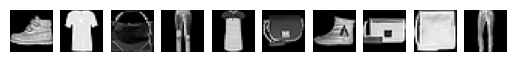

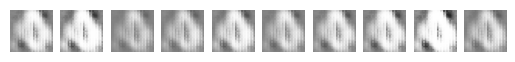

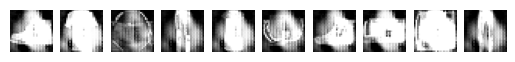

Autoencoder reconstruction error (infinity to 0): 7.092
Counterfactual prediction gain (0 to 1): 0.878
Sparsity (L1, infinity to 0): 0.448


  0%|          | 10/10000 [00:34<9:28:31,  3.41s/it]


KeyboardInterrupt: 

In [45]:
method_name = "countergan"
countergan = train_countergan(2, 3, 10000, baseline_classifier, discriminator, generator, batches)

In [19]:
models_save_dir = r'D:\PycharmProjects\CF-Robustness-Benchmark\cf_output\fmnist\countergan_binary\checkpoints'

In [20]:
generator.save(osp.join(models_save_dir, 'generator_iter_2900.keras'))
discriminator.save(osp.join(models_save_dir, 'discriminator_iter_2900.keras'))

# Evaluation of CounterGAN

Load perts of CounteRGAN

In [30]:
generator = load_model(r'D:\PycharmProjects\RecourseRobustnessBenchmark\carla_visual\recourse_methods\countergan\weights\binary_generator_targetc_8_5000it.keras')
discriminator = load_model(r'D:\PycharmProjects\RecourseRobustnessBenchmark\carla_visual\recourse_methods\countergan\weights\binary_discriminator_targetc_8_5000it.keras')

In [13]:
class_ind = np.where(tf.argmax(y_test, axis=1)==class_encodings[INIT_CLASS])[0]
factuals = X_test[class_ind]
labels =  y_test[class_ind]

# factuals = tf.concat(factuals, axis=0)
# labels = tf.concat(labels, axis=0)

shuffled_indices = tf.random.shuffle(tf.range(labels.shape[0]))  # Generate shuffled indices
labels = tf.gather(labels, shuffled_indices)  # Reorder labels

# Shuffle images if needed to align with new label order
factuals = tf.gather(factuals, shuffled_indices)
print('Total number of factual instances: ', factuals.shape[0])

Total number of factual instances:  2000


In [14]:
predictions = tf.argmax(baseline_classifier.predict(factuals, verbose=0), axis=1)
_, valid_indices = np.where([predictions == tf.argmax(labels, axis=1)])
factuals = tf.gather(factuals, valid_indices)
labels = tf.gather(labels, valid_indices) 

In [15]:
cfes = generator.predict(factuals, verbose=0)
cfes_pred = tf.argmax(baseline_classifier.predict(cfes, verbose=0), axis=1)
validity = len(np.where(cfes_pred == tf.ones_like(cfes_pred)*class_encodings[DESIRED_CLASS])[0]) / len(cfes)
print(f'Validity of the generated CFEs: {validity:.2%}')

Validity of the generated CFEs: 0.00%


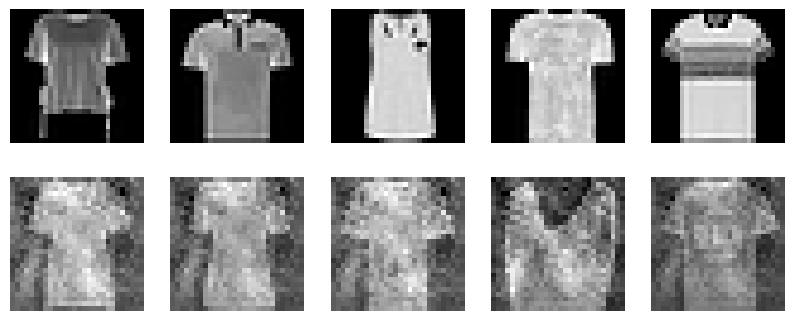

In [16]:
n_rows = 2
n_cols = 5

k = 0

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 4))
for i in range(n_rows):
    for j in range(n_cols):
        if i == 0:
            axs[i, j].imshow(factuals[k].numpy(), cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_ylabel('CFE /wo noise')
        else:
            axs[i, j].imshow(cfes[k], cmap='gray')
            # axs[i, j].set_title('epsilon='+str(noise)) 
            axs[i, j].axis('off')
            axs[i, j].set_ylabel('CFE /w noise')
        k += 1
plt.show()

## Robustness Evaluation

### Local Instability

In [35]:
from src.evaluation.local_instability import perturb_sample
from src.evaluation.local_instability import calculate_sparsity, calculate_ssim
from src.utils.visualization import plot_boxplot

In [36]:
noise_levels = [0.001, 0.0025, 0.005, 0.0075, 0.01]

In [37]:
factuals_pert = {}
pert_indices = {}

for noise_level in noise_levels:
    pert_sample = perturb_sample(factuals, n_samples=1, noise_magnitude=noise_level) #.permute(0, 2, 3, 1).numpy()

    # Check whether perturbed instances lead to the same class prediction
    predictions = tf.argmax(baseline_classifier.predict(pert_sample, verbose=0), axis=1)
   
    targets = tf.argmax(labels, axis=1)
    indices = np.where(predictions == targets)[0]
    pert_indices[noise_level] = indices

    factuals_pert[noise_level] = tf.gather(pert_sample, indices, axis=0)
    print(f'Number of valid perturbed factuals for the added noise level {noise_level}: ', factuals_pert[noise_level].shape[0])

Number of valid perturbed factuals for the added noise level 0.001:  1135
Number of valid perturbed factuals for the added noise level 0.0025:  1134
Number of valid perturbed factuals for the added noise level 0.005:  1133
Number of valid perturbed factuals for the added noise level 0.0075:  1132
Number of valid perturbed factuals for the added noise level 0.01:  1129


In [38]:
from functools import reduce

n = 100
final_indices = reduce(np.intersect1d, (valid_indices, *list(pert_indices.values())))[:n]

In [41]:
factuals = tf.gather(factuals, final_indices) 
labels = tf.gather(labels, final_indices)

In [42]:
cfes = tf.gather(cfes, final_indices).numpy()
factuals_pert = {k : tf.gather(v, final_indices) for k, v in factuals_pert.items()}

In [43]:
cfes_pert =  {k: generator.predict(v, verbose=0) for k, v in factuals_pert.items()} 

In [ ]:
validity_list = []
for noise_level, cf_prediction in zip(noise_levels, cf_pert_predictions):
    validity = calculate_validity(cf_prediction, cf_targets_tensor)
    print(f'Validity under the noise level {noise_level}:', validity)
    validity_list.append(validity)

output_dir = r'D:\PycharmProjects\RecourseRobustnessBenchmark\experiments\binary_classification\output'
with open(osp.join(output_dir, f'countergan_bin_validity_pert_n{n}.pkl'), 'wb') as f:
    pickle.dump(validity_list, f)

In [59]:
cfes_pert_predictions = {}
validity_list = []

for noise_level in noise_levels:
    predictions = tf.argmax(baseline_classifier.predict(cfes_pert[noise_level], verbose=0), axis=1)
    cfes_pert_predictions[noise_level] = predictions

    validity = len(np.where(predictions == tf.ones_like(predictions)*class_encodings[DESIRED_CLASS])[0]) / len(cfes)
    print(f'Validity of the generated CFEs for correctly classified instances: {validity:.2%}')
    validity_list.append(validity)

output_dir = r'D:\PycharmProjects\Counterfactual-Robustness-Benchmark\output\countergan_binary'
with open(osp.join(output_dir, 'countergan_bin_validity.pkl'), 'wb') as f:
    pickle.dump(validity_list, f)

Validity of the generated CFEs for correctly classified instances: 15.00%
Validity of the generated CFEs for correctly classified instances: 14.00%
Validity of the generated CFEs for correctly classified instances: 11.00%
Validity of the generated CFEs for correctly classified instances: 11.00%
Validity of the generated CFEs for correctly classified instances: 9.00%


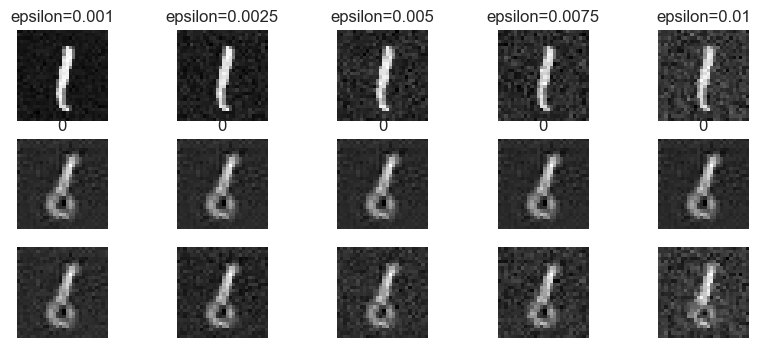

In [44]:
n_rows = 3
n_cols = 5

ind = 20

# factuals_pert = {}    
cfes_pert_predictions = {}

for noise_level in noise_levels:
    # factuals_pert[noise_level] = perturb_sample(factuals, n_samples=1, noise_magnitude=noise_level)
    cfes_pert_predictions[noise_level] = tf.argmax(baseline_classifier.predict(cfes_pert[noise_level], verbose=0), axis=1)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 4))
for i in range(n_rows):
    for j in range(n_cols):
        noise = noise_levels[j]
        if i == 0: 
            pert_image = factuals_pert[noise][ind]  #perturb_sample(factuals_tensor[ind].unsqueeze(0), noise_magnitude=noise).squeeze().squeeze()
            axs[i, j].imshow(pert_image, cmap='gray')
            axs[i, j].set_title('epsilon='+str(noise)) 
            axs[i, j].axis('off')
        elif i == 1:
            axs[i, j].imshow(cfes[ind].squeeze(), cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title(str(cfes_pert_predictions[noise_level][ind].numpy().item())) 
            axs[i, j].set_ylabel('CFE /wo noise')
        else:
            axs[i, j].imshow(cfes_pert[noise][ind], cmap='gray')
            # axs[i, j].set_title('epsilon='+str(noise)) 
            axs[i, j].axis('off')
            axs[i, j].set_ylabel('CFE /w noise')
plt.show()

In [45]:
# Calculating L1 distance between the explanations of original and perturbed instances
l1_list = []
ssim_list = []


for i, noise_level in tqdm(enumerate(cfes_pert.keys())):
    l1_temp = []
    ssim_temp = []

    cfs_pert = cfes_pert[noise_level]

    for i in tqdm(range(cfes_pert[noise_level].shape[0])): 

        l1_distance = calculate_sparsity(cfes[i].flatten(), cfes_pert[noise_level][i].flatten()).item()
        # sum(abs(cfes[i].flatten() - cfes_pert[noise_level][i].flatten())) #
        l1_temp.append(l1_distance)

        ssim = calculate_ssim(torch.Tensor(cfes[i]).permute(2, 0, 1).unsqueeze(0), 
                              torch.Tensor(cfes_pert[noise_level][i]).permute(2, 0, 1).unsqueeze(0)).item()
        ssim_temp.append(ssim)

    print(f'Average Instability (L1) for the set of counterfactuals of size : {np.mean(l1_temp)}')    
    l1_list.append(l1_temp)
    
    print(f'Average SSIM for the set of counterfactuals of size : {np.mean(ssim_temp)}')    
    ssim_list.append(ssim_temp)

100%|██████████| 100/100 [00:00<00:00, 294.62it/s]
1it [00:00,  2.87it/s]

Average Instability (L1) for the set of counterfactuals of size : 20.15952703475952
Average SSIM for the set of counterfactuals of size : 0.9100335168838501


100%|██████████| 100/100 [00:00<00:00, 387.79it/s]
2it [00:00,  3.36it/s]

Average Instability (L1) for the set of counterfactuals of size : 32.76341459274292
Average SSIM for the set of counterfactuals of size : 0.8130669122934342


100%|██████████| 100/100 [00:00<00:00, 364.12it/s]
3it [00:00,  3.45it/s]

Average Instability (L1) for the set of counterfactuals of size : 48.02870323181153
Average SSIM for the set of counterfactuals of size : 0.7001548224687576


100%|██████████| 100/100 [00:00<00:00, 344.58it/s]
4it [00:01,  3.43it/s]

Average Instability (L1) for the set of counterfactuals of size : 61.15798969268799
Average SSIM for the set of counterfactuals of size : 0.6127428635954857


100%|██████████| 100/100 [00:00<00:00, 294.82it/s]
5it [00:01,  3.26it/s]

Average Instability (L1) for the set of counterfactuals of size : 73.39838424682617
Average SSIM for the set of counterfactuals of size : 0.5417368584871292


In [57]:
output_dir = r'D:\PycharmProjects\Counterfactual-Robustness-Benchmark\output\countergan_binary'
with open(osp.join(output_dir, 'countergan_li_l1.pkl'), 'wb') as f:
    pickle.dump(l1_list, f)

with open(osp.join(output_dir, 'countergan_ssim.pkl'), 'wb') as f:
    pickle.dump(ssim_list, f)

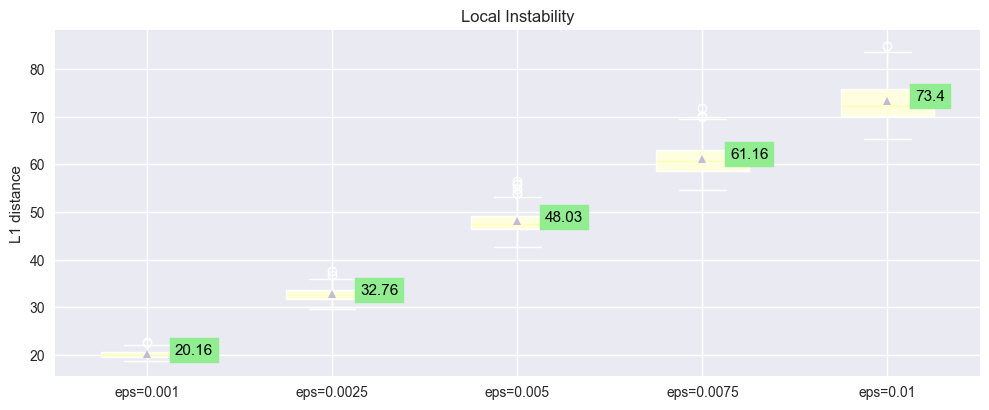

In [46]:
plt.style.use("seaborn-v0_8-notebook")
plt.rcParams['figure.figsize'] = [10, 4]

plot_boxplot(data=l1_list, mean_values=[np.round(np.mean(inst),2) for inst in l1_list],
             tick_labels=[f'eps={noise_level}' for noise_level in noise_levels],
             y_label='L1 distance', colors=['lightyellow'], title='Local Instability')

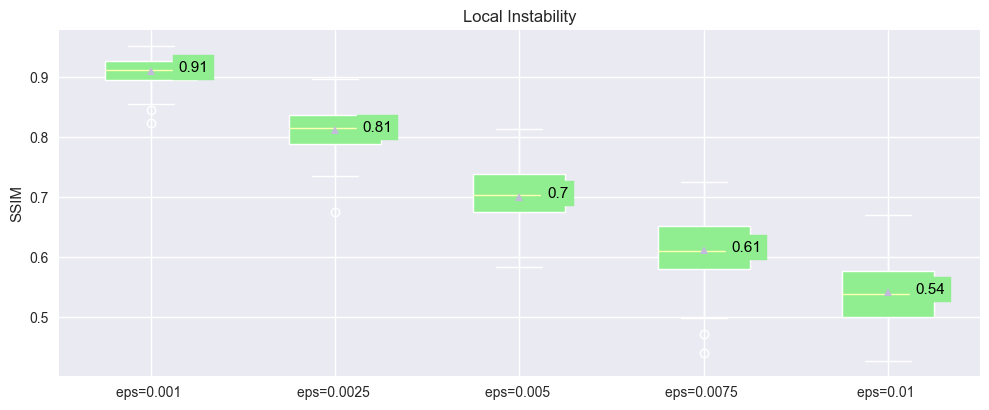

In [47]:
plot_boxplot(data=ssim_list, mean_values=[np.round(np.mean(inst),2) for inst in ssim_list],
             tick_labels=[f'eps={noise_level} ' for noise_level in noise_levels],
             y_label='SSIM', colors=['lightgreen'], title='Local Instability')

## Local Lipschitz Continuity

In [59]:
original_points = factuals
original_cfes = cfes
print("Are the lengths of initial points (factuals) and CFEs generated for them equal :", original_cfes.shape[0] == original_points.shape[0])


Are the lengths of initial points (factuals) and CFEs generated for them equal : True


In [60]:
noise_magnitude = 0.001

lip_estimates = []

for original_point, original_cfe in tqdm(zip(original_points, original_cfes), total=original_points.shape[0]):

    neighbor_points = perturb_sample(tf.expand_dims(original_point, axis=0), n_samples=50, noise_magnitude=noise_magnitude)    
    neighbor_cfes = generator.predict(neighbor_points, verbose=False)

    lip_estimate = 0
    for m, p in zip(neighbor_cfes, neighbor_points):
        num = np.linalg.norm((original_cfe - m).flatten(), ord=2) 
        denom = np.linalg.norm((original_point.numpy() - p).flatten(), ord=2)
        lip = num / denom
        lip_estimate = max(lip, lip_estimate)
 
    lip_estimates.append(lip_estimate)


100%|██████████| 100/100 [01:00<00:00,  1.64it/s]


In [61]:
output_dir = r'D:\PycharmProjects\Counterfactual-Robustness-Benchmark\output\countergan_binary'
with open(osp.join(output_dir, 'countergan_lle.pkl'), 'wb') as f:
    pickle.dump(lip_estimates, f)

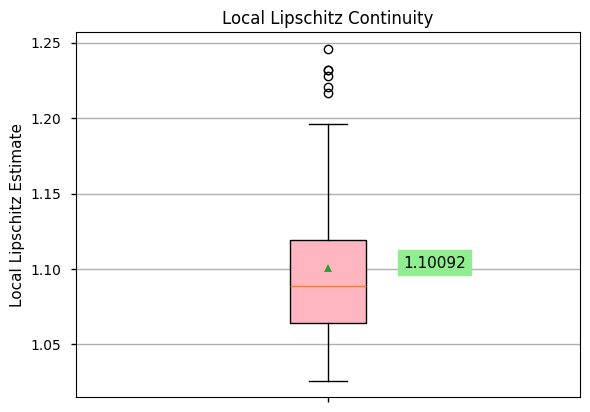

In [62]:
plt.rcParams['figure.figsize'] = [6, 4]
plot_boxplot(data=lip_estimates, mean_values=[np.round(np.mean(lip_estimates), 5)],
             tick_labels=[''],
             y_label='Local Lipschitz Estimate', colors=['lightpink'], title='Local Lipschitz Continuity')

## Invalidation Rate

Weights reinitialization

In [48]:
classifiers_weights_dir = r'D:\PycharmProjects\Counterfactual-Robustness-Benchmark\src\models\weights\tf\binary_mc'

batch_size = 128


classifiers_list = []
for clf_fname in os.listdir(classifiers_weights_dir):
    cnn_perturbed = load_model(osp.join(classifiers_weights_dir, clf_fname), 
                            custom_objects={'CNNtf': CNNtf})
    classifiers_list.append(cnn_perturbed)

    logits = cnn_perturbed.predict(X_test)
    accuracy = (logits.argmax(axis=1) == y_test[:, 0]).numpy().mean()
    print(f"Classifier accuracy test: {accuracy:.3%}")

66/66 [==============================] - 1s 7ms/step
Classifier accuracy test: 99.905%
66/66 [==============================] - 1s 6ms/step
Classifier accuracy test: 99.573%
66/66 [==============================] - 0s 6ms/step
Classifier accuracy test: 99.953%
66/66 [==============================] - 0s 5ms/step
Classifier accuracy test: 99.953%
66/66 [==============================] - 0s 5ms/step
Classifier accuracy test: 99.953%
66/66 [==============================] - 0s 5ms/step
Classifier accuracy test: 99.763%
66/66 [==============================] - 0s 5ms/step
Classifier accuracy test: 100.000%
66/66 [==============================] - 0s 5ms/step
Classifier accuracy test: 99.905%
66/66 [==============================] - 0s 5ms/step
Classifier accuracy test: 99.953%
66/66 [==============================] - 0s 6ms/step
Classifier accuracy test: 99.953%


Evaluate IR only for the valid explanations for the baseline classifier

In [49]:
predictions = tf.argmax(baseline_classifier.predict(cfes, verbose=0), axis=1)
indices = np.where(predictions == tf.ones_like(predictions)*class_encodings[DESIRED_CLASS])[0]
cfes_subsample = tf.gather(cfes, indices)
cfes_subsample.shape

validity = len(np.where(predictions == tf.ones_like(predictions)*class_encodings[DESIRED_CLASS])[0]) / len(cfes)
print(f'Validity of the generated CFEs for correctly classified instances: {validity:.2%}')

Validity of the generated CFEs for correctly classified instances: 15.00%


In [52]:
invalidation_rate_list = []
validity_list = []
total_cfs = cfes.shape[0]

for i, classifier in enumerate(classifiers_list):
    invalidation_rate = 0

    baseline_pred = tf.argmax(baseline_classifier.predict(cfes_subsample, verbose=0), axis=1)
    alternative_pred = tf.argmax(classifier.predict(cfes_subsample, verbose=0), axis=1)

    inv_indices = tf.where(baseline_pred != alternative_pred)
    inv_instances = tf.gather(cfes_subsample, inv_indices) 
    inv_predictions = tf.gather(alternative_pred, inv_indices)
    print('number of invalidated instances', inv_indices.shape[0])
    # fig, ax = plt.subplots(1, 3)
    # for i in range(3):
    #     ax[i].imshow(inv_instances[i][0], cmap='gray')
    #     ax[i].axis('off')
    #     ax[i].set_title(inv_predictions[i].numpy())
    
    invalidation_rate = inv_indices.shape[0] / total_cfs
    invalidation_rate_list.append(invalidation_rate)

    validity = tf.where(alternative_pred == class_encodings[DESIRED_CLASS]).shape[0] / total_cfs

    validity_list.append(validity)

    print(f'Model {i}: IR={invalidation_rate}, validity={validity}\n')

print(f'Average IR among {len(classifiers_list)} models: ', np.mean(invalidation_rate_list), np.std(invalidation_rate_list))
print(f'Average VaR among {len(classifiers_list)} models: ', np.mean(validity_list), np.std(validity_list))


number of invalidated instances 1
Model 0: IR=0.01, validity=0.14

number of invalidated instances 7
Model 1: IR=0.07, validity=0.08

number of invalidated instances 0
Model 2: IR=0.0, validity=0.15

number of invalidated instances 3
Model 3: IR=0.03, validity=0.12

number of invalidated instances 0
Model 4: IR=0.0, validity=0.15

number of invalidated instances 0
Model 5: IR=0.0, validity=0.15

number of invalidated instances 0
Model 6: IR=0.0, validity=0.15

number of invalidated instances 0
Model 7: IR=0.0, validity=0.15

number of invalidated instances 2
Model 8: IR=0.02, validity=0.13

number of invalidated instances 2
Model 9: IR=0.02, validity=0.13

Average IR among 10 models:  0.015 0.021095023109728987
Average VaR among 10 models:  0.135 0.02109502310972898


## Stability 

In [54]:
k = 1000
sigma = 0.001

average_stability_list = []


for i, classifier in enumerate(classifiers_list):
    stability_list = []
    stability = 0

    original_logits = classifier.predict(cfes_subsample, verbose=0)
    # To calculate stability of only valid CFE, they need to be identified
    valid_cfs_ind = tf.where(original_logits.argmax(axis=1) == class_encodings[DESIRED_CLASS])[:, 0]
    original_logits_subsample = tf.gather(original_logits, valid_cfs_ind)

    original_probabilities = tf.nn.softmax(original_logits_subsample, axis=-1)[:, class_encodings[DESIRED_CLASS]]

    valid_cfs_subsample = tf.gather(cfes_subsample, valid_cfs_ind)
    cf_sample_pert = perturb_sample(valid_cfs_subsample, n_samples=k, noise_magnitude=sigma)

    logits = classifier.predict(cf_sample_pert, verbose=0)
    probabilities = tf.nn.softmax(logits, axis=-1)[:, class_encodings[DESIRED_CLASS]]

    for j in range(original_probabilities.shape[0]):
        original_probabilities_i = tf.expand_dims(original_probabilities[j], axis=-1)
        # print(original_probabilities_i.shape)
        model_variance = abs(original_probabilities_i - probabilities[j*k : j*k+k])
        # print(probabilities[i*k:i*k+k].shape)
        # print(model_variance.shape)
        stability = (probabilities[j*k:j*k+k] - model_variance).numpy().mean()
        stability_list.append(stability)

    avg_i_stability = np.mean(stability_list)
    print(f'Average Stability of the model {i}: {round(avg_i_stability.item(), 3)} +- {round(np.std(stability_list).item(), 2)}')
    average_stability_list.append(avg_i_stability)


Average Stability of the model 0: 0.607 +- 0.04
Average Stability of the model 1: 0.589 +- 0.04
Average Stability of the model 2: 0.774 +- 0.08
Average Stability of the model 3: 0.799 +- 0.04
Average Stability of the model 4: 0.666 +- 0.06
Average Stability of the model 5: 0.891 +- 0.1
Average Stability of the model 6: 0.836 +- 0.08
Average Stability of the model 7: 0.866 +- 0.07
Average Stability of the model 8: 0.618 +- 0.04
Average Stability of the model 9: 0.856 +- 0.05


In [55]:
print(f"Average stability across {len(average_stability_list)} equally performative models: \
{round(np.mean(average_stability_list).item(), 3)} +- {round(np.std(average_stability_list).item(), 3)}")

Average stability across 10 equally performative models: 0.75 +- 0.112
